# Dueling Double Deep Q-Network

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
from collections import deque

import gym
import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, Add
from keras.optimizers import Adam, RMSprop
from keras import backend as K

Using TensorFlow backend.


In [3]:
plt.style.use('ggplot')

## Set Environment

In [4]:
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(4,)
Action space Discrete(2)


## Build DQN Architecture

In [6]:
def DQN(state_size, action_size):
    
    x_input = Input(state_size)
    x = Dense(512, input_shape=state_size, activation='relu', kernel_initializer='he_uniform')(x_input)
    x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
    
    state_value = Dense(1, kernel_initializer='he_uniform')(x)
    state_value = Lambda(lambda state: K.expand_dims(state[:, 0], -1), output_shape=(action_size,))(state_value)
    
    action_advantage = Dense(action_size, kernel_initializer='he_uniform')(x)
    action_advantage = Lambda(lambda action: action[:, :] - K.mean(action[:, :], keepdims=True), output_shape=(action_size,))(action_advantage)
    x = Add()([state_value, action_advantage])
    
    model = Model(inputs=x_input, outputs=x, name='CartPole-Dueling DDQN model')
    model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=25e-5, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

## Define D3QN Agent

In [7]:
class D3QNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, env_name, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.env = gym.make(env_name).unwrapped
        self.env.max_episode_steps = 500 # set by openai's gym
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.num_episodes = 500
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1000
        
        self.tau = 0.1
        
        # init variables for ploting training process
        self.scores, self.episodes, self.average = [], [], []
        
        # create main model
        self.model = DQN(state_size=(self.state_size,), action_size=self.action_size)
        self.target_model = DQN(state_size=(self.state_size,), action_size=self.action_size)
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay memory."""
        
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
                
    def replay(self):
        
        if len(self.memory) < self.train_start: return
        
        # randomly sample mini-batch from the memory
        batch = random.sample(self.memory, self.batch_size)
        
        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []
        
        for i_batch in range(self.batch_size):
            state[i_batch] = batch[i_batch][0]
            action.append(batch[i_batch][1])
            reward.append(batch[i_batch][2])
            next_state[i_batch] = batch[i_batch][3]
            done.append(batch[i_batch][4])
            
        # do batch prediction to save speed
        target = self.model.predict(state)
        target_next = self.model.predict(next_state)
        target_eval = self.target_model.predict(next_state)
        
        for i_batch in range(self.batch_size):
            # correction on the Q value for the action used
            if done[i_batch]:
                target[i_batch][action[i_batch]] = reward[i_batch]
            else:
                # current Q Network selects the action
                # a'_max = argmax_a' Q(s', a')
                a_max = np.argmax(target_next[i_batch])
                
                # target Q Network evaluates the action
                # Q_max = Q_target(s', a'_max)
                target[i_batch][action[i_batch]] = reward[i_batch] + self.gamma * (target_eval[i_batch][a_max])
                
        # train the neural network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)
        
    # after some time interval, update the target model to be same with model
    def soft_update_target_model(self):
    
        Q_model_theta = self.model.get_weights()
        target_model_theta = self.target_model.get_weights()
        counter = 0
        
        for Q_weight, target_weight in zip(Q_model_theta, target_model_theta):
            target_weight = target_weight * (1-self.tau) + Q_weight * self.tau
            target_model_theta[counter] = target_weight
            counter += 1
        self.target_model.set_weights(target_model_theta)
        
    def act(self, state):
        """Returns actions for given state as per current policy."""
        
        if np.random.random() <= self.epsilon:
            action = random.randrange(self.action_size)
            return action
        else:
            action = np.argmax(self.model.predict(state))
            return action
        
    def save(self, agent_location):
        self.model.save(agent_location)
        
    def load(self, agent_location):
        self.model = load_model(agent_location)
        
    plt.figure(figsize=(10, 5))
    def plot_model(self, score, episode):
        
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores) / len(self.scores))
        
        plt.plot(self.episodes, self.scores, 'green')
        plt.plot(self.episodes, self.average, 'red')
        plt.xlabel('Number of episodes', fontsize=12)
        plt.ylabel('Total scores', fontsize=12)
        
        plt.show()
        
        return str(self.average[-1])[:5]
    
    def train(self):
        
        best_score = -np.inf
        for i_episode in range(1, self.num_episodes+1):
            
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            
            score = 0
            while not done:
                # self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or score == self.env.max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                    
                self.memorize(state, action, reward, next_state, done)
                state = next_state
                
                score += 1
                if done:
                    clear_output(wait=True)
                    
                    # every step softly update target model
                    self.soft_update_target_model()
                    
                    # every episode, plot the result
                    average = self.plot_model(score, i_episode)
                    
                    print(f'Episode: {i_episode}/{self.num_episodes}, Best Score: {best_score}, Average: {average}, Epsilon: {self.epsilon:.2}')
                    
                    if score > best_score:
                        best_score = score
                        if best_score > self.env.max_episode_steps:
                            print(f'Saving trained agent as D3QN_{ENV_NAME}.h5')
                            if not os.path.exists('./agents/'): os.makedirs('./agents/')
                            self.save(f'./agents/D3QN_{ENV_NAME}.h5')
                            continue
                    
                self.replay()
    
    def watch(self, num_episodes):
        
        self.load(f'./agents/D3QN_{ENV_NAME}.h5')
        best_score = -np.inf
        for i_episode in range(1, num_episodes+1):
            
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            
            score = 0
            while not done:
                
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                
                score += 1
                if score > best_score: best_score = score
                state = np.reshape(next_state, [1, self.state_size])
                if done:
                    clear_output(wait=True)
                    print(f'Episode: {i_episode}/{self.num_episodes}, Best Score: {best_score}', end='')
                    break

In [8]:
agent = D3QNAgent(env_name='CartPole-v1', 
                  state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2560        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           16448       dense_2[0][0]                    
__________

In [9]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

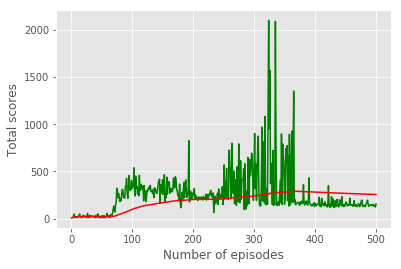

Episode: 500/500, Best Score: 2100, Average: 255.6, Epsilon: 0.001


In [10]:
agent.train()

## Evaluate The Agent

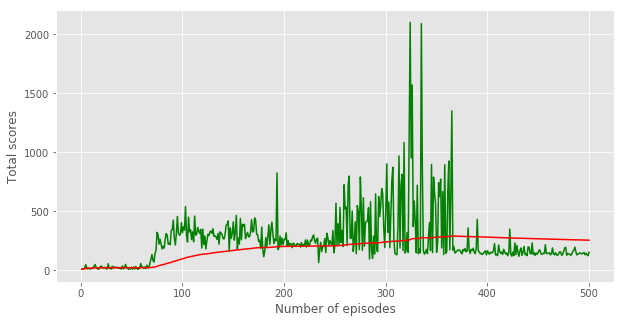

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(agent.episodes, agent.scores, 'green')
plt.plot(agent.episodes, agent.average, 'red')
plt.xlabel('Number of episodes', fontsize=12)
plt.ylabel('Total scores', fontsize=12)
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_training_result_average_d3qn_nn.png')

plt.show()

## Watch The Smart Agent

In [12]:
agent.load(f'./agents/D3QN_{ENV_NAME}.h5')

In [13]:
agent.watch(num_episodes=3)

Episode: 3/500, Best Score: 1717

---